# Exploring topic modelling

## Imports, loading data

In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from collections import Counter
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from transformers import pipeline


In [242]:
df = pd.read_csv("The_Office_lines.csv")
df.head()

,id,season,episode,scene,line_text,speaker,deleted
0,1,1,1,1,All right Jim. Your quarterlies look very good. How are things at the library?,Michael,False
1,2,1,1,1,"Oh, I told you. I couldn't close it. So...",Jim,False
2,3,1,1,1,"So you've come to the master for guidance? Is this what you're saying, grasshopper?",Michael,False
3,4,1,1,1,"Actually, you called me in here, but yeah.",Jim,False
4,5,1,1,1,"All right. Well, let me show you how it's done.",Michael,False


## Exploring data, cleaning and preprocessing

In [243]:
df.dtypes

id            int64
season        int64
episode       int64
scene         int64
line_text    object
speaker      object
deleted        bool
dtype: object

In [244]:
df = df.convert_dtypes()

In [245]:
df.dtypes

id             Int64
season         Int64
episode        Int64
scene          Int64
line_text     string
speaker       string
deleted      boolean
dtype: object

In [246]:
df['line_length']  = df.line_text.str.len()

In [247]:
df.line_length.describe()

count    59909.000000
mean        59.692467
std         70.528507
min          1.000000
25%         17.000000
50%         37.000000
75%         75.000000
max       1439.000000
Name: line_length, dtype: float64

The average amount of characters in each line of dialogue is around 60, with some lines having just one character. It might be useful to remove some of these short lines at some point

In [248]:
df['line_text_pp'] = df['line_text'].apply(lambda x:x.lower())

In [249]:
stop_words = set(nltk.corpus.stopwords.words('english'))

In [250]:
def remove_stopwords(dialogues):
    remove_stopwords_ufunc = np.frompyfunc(lambda x: ' '.join([w for w in x.split() if w.lower() not in stop_words]), 1, 1)
    dialogues = remove_stopwords_ufunc(dialogues)
    return dialogues

In [251]:
df['line_text_pp'] = remove_stopwords(df.line_text_pp)

In [253]:
common_words_list = [word for word, count in Counter(" ".join(df.line_text_pp).split()).most_common(100)]


In [254]:
def remove_commonwords(dialogues):
    remove_common_words_ufunc = np.frompyfunc(lambda x: ' '.join([w for w in x.split() if w.lower() not in common_words_list]), 1, 1)
    dialogues = remove_common_words_ufunc(dialogues)
    return dialogues

In [255]:
df['line_text_pp'] = remove_commonwords(df.line_text_pp)

In [256]:
df.head()

,id,season,episode,scene,line_text,speaker,deleted,line_length,line_text_pp
0,1,1,1,1,All right Jim. Your quarterlies look very good. How are things at the library?,Michael,False,78,jim. quarterlies things library?
1,2,1,1,1,"Oh, I told you. I couldn't close it. So...",Jim,False,42,told close so...
2,3,1,1,1,"So you've come to the master for guidance? Is this what you're saying, grasshopper?",Michael,False,83,"master guidance? saying, grasshopper?"
3,4,1,1,1,"Actually, you called me in here, but yeah.",Jim,False,42,"actually, called here,"
4,5,1,1,1,"All right. Well, let me show you how it's done.",Michael,False,47,show done.


In [257]:
df['new_line_length']  = df.line_text_pp.str.len()
df.new_line_length.describe()

count    59909.000000
mean        32.683203
std         40.661115
min          0.000000
25%          8.000000
50%         20.000000
75%         42.000000
max        693.000000
Name: new_line_length, dtype: float64

Based on some preliminary topic modelling attempts, I want to try removing character names and words with 3 or less characters.

In [277]:
def remove_names(df, col):
    character_names = ['phyllis', 'darryl', 'michael', 'pam', 'kevin', 'angela', 'dwight', 'creed', 'jim', 'ryan', 'erin', 'andy', 'oscar', 'stanley', 'scott', 'jan', 'schrute', 'david', 'kelly', 'meredith', 'nellie', 'wallas', 'robert', 'deangelo', 'holly']
    # Create a regular expression pattern that matches any of the names in the character_names list
    pattern = '|'.join(r"\b{}\b".format(name) for name in character_names)
    # Replace the matched words in the specified column with an empty string
    df[col] = df[col].str.replace(pattern, '', regex=True)
    return df

In [259]:
df = remove_names(df, 'line_text_pp')

In [260]:
def remove_short_words(df, col):
    # Create a regular expression pattern that matches any word of four characters or fewer
    pattern = r"\b\w{1,4}\b"
    # Replace the matched words in the specified column with an empty string
    df[col] = df[col].str.replace(pattern, '', regex=True)
    return df

In [261]:
df = remove_short_words(df, 'line_text_pp')

In [262]:
df.head()

,id,season,episode,scene,line_text,speaker,deleted,line_length,line_text_pp,new_line_length
0,1,1,1,1,All right Jim. Your quarterlies look very good. How are things at the library?,Michael,False,78,. quarterlies things library?,32
1,2,1,1,1,"Oh, I told you. I couldn't close it. So...",Jim,False,42,close ...,16
2,3,1,1,1,"So you've come to the master for guidance? Is this what you're saying, grasshopper?",Michael,False,83,"master guidance? saying, grasshopper?",37
3,4,1,1,1,"Actually, you called me in here, but yeah.",Jim,False,42,"actually, called ,",22
4,5,1,1,1,"All right. Well, let me show you how it's done.",Michael,False,47,.,10


After removing stopwords and the 100 most common words (as these don't appear to add meaning to the dialogue), the dialogue is quite short! Hopefully, this will still enable use to perform topic modelling!

In [263]:
df['new_line_length']  = df.line_text_pp.str.len()
df.new_line_length.describe()

count    59909.000000
mean        24.822881
std         32.803317
min          0.000000
25%          6.000000
50%         14.000000
75%         32.000000
max        530.000000
Name: new_line_length, dtype: float64

### I want to try grouping each scene together:

This may make topic modelling better?

In [268]:
# group by season, episode, and scene, and concatenate the line_text column
df_grouped_by_scene = df.groupby(['season', 'episode', 'scene'])[['line_text', 'line_text_pp']].apply(lambda x: pd.Series({
    'line_text': ' '.join(x['line_text'].dropna().astype(str)),
    'line_text_pp': ' '.join(x['line_text_pp'].dropna().astype(str))
})).reset_index()

# print the result
df_grouped_by_scene.head()

,season,episode,scene,line_text,line_text_pp
0,1,1,1,"All right Jim. Your quarterlies look very good. How are things at the library? Oh, I told you. I couldn't close it. So... So you've come to the master for guidance? Is this what you're saying, grasshopper? Actually, you called me in here, but yeah. All right. Well, let me show you how it's done.",". quarterlies things library? close ... master guidance? saying, grasshopper? actually, called , ."
1,1,1,2,"[on the phone] Yes, I'd like to speak to your office manager, please. Yes, hello. This is Michael Scott. I am the Regional Manager of Dunder Mifflin Paper Products. Just wanted to talk to you manager-a-manger. [quick cut scene] All right. Done deal. Thank you very much, sir. You're a gentleman and a scholar. Oh, I'm sorry. OK. I'm sorry. My mistake. [hangs up] That was a woman I was talking to, so... She had a very low voice. Probably a smoker, so... [Clears throat] So that's the way it's done.","[ phone] ' speak office manager, please. hello. . regional manager dunder mifflin paper products. wanted manager--manger. [quick scene] . , . gentleman scholar. sorry. sorry. mistake. [hangs ] woman talking , ... voice. probably smoker, ... [clears throat] ."
2,1,1,3,"I've, uh, I've been at Dunder Mifflin for 12 years, the last four as Regional Manager. If you want to come through here... See we have the entire floor. So this is my kingdom, as far as the eye can see. This is our receptionist, Pam. Pam! Pam-Pam! Pam Beesly. Pam has been with us for... forever. Right, Pam? Well. I don't know. If you think she's cute now, you should have seen her a couple of years ago. [growls] What? Any messages? Uh, yeah. Just a fax. Oh! Pam, this is from Corporate. How many times have I told you? There's a special filing cabinet for things from corporate. You haven't told me. It's called the wastepaper basket! Look at that! Look at that face.","', dunder mifflin years, regional manager. ... entire floor. kingdom, . receptionist, . ! -! beesly. ... forever. right, ? . , couple years . [growls] messages? . ! , corporate. times special filing cabinet things corporate. called wastepaper basket! ! ."
3,1,1,4,"People say I am the best boss. They go, 'God we've never worked in a place like this before. You're hilarious.' 'And you get the best out of us.' [shows the camera his WORLD'S BEST BOSS mug] I think that pretty much sums it up. I found it at Spencer Gifts.",". , ' ' worked place before. hilarious.' ' .' [shows camera world' ] pretty . found spencer gifts."
4,1,1,5,[singing] Shall I play for you? Pa rum pump um pum [Imitates heavy drumming] I have no gifts for you. Pa rum pump um pum [Imitates heavy drumming],[singing] shall [imitates heavy drumming] gifts [imitates heavy drumming]


### And I want to try grouping each episode together:

This may make topic modelling better?

In [269]:
# group by season, episode, and scene, and concatenate the line_text column
df_grouped_by_episode = df.groupby(['season', 'episode'])[['line_text', 'line_text_pp']].apply(lambda x: pd.Series({
    'line_text': ' '.join(x['line_text'].dropna().astype(str)),
    'line_text_pp': ' '.join(x['line_text_pp'].dropna().astype(str))
})).reset_index()

# print the result
df_grouped_by_episode.head()

season  episode  \
0       1        1   
1       1        2   
2       1        3   
3       1        4   
4       1        5   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [264]:
#df_downsized = df.loc[df['new_line_length'] > 50]


### Topic modelling: LDA and NMF

In [ ]:
# source: https://www.kaggle.com/code/sathvisiva/topic-modelling-and-sentiment-analysis

In [270]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx , topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words -1:-1]]))


In [271]:
no_features = 1000
count_vectorizer = CountVectorizer(max_df = 0.95, min_df = 2, max_features=no_features, stop_words='english')
fitted_count_vectorizer = count_vectorizer.fit_transform(df_grouped_by_scene.line_text_pp)
vectorized_feature_names = count_vectorizer.get_feature_names()


/Users/elinewesterbeek/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [272]:
no_topic = 8

In [273]:
nmf = NMF(n_components=no_topic, random_state = 1, alpha =.1, l1_ratio=.5, init = 'nndsvd').fit(fitted_count_vectorizer)


/Users/elinewesterbeek/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/Users/elinewesterbeek/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [275]:
lda = LatentDirichletAllocation(n_components=no_topic, max_iter = 5, learning_method = 'online', learning_offset=50., random_state=0).fit(fitted_count_vectorizer)


In [274]:
no_top_words = 10
display_topics(nmf ,vectorized_feature_names, no_top_words)

Topic 0:
alright everybody actually things talking right better really looks laughs
Topic 1:
phone hello hangs rings client calling listen imitating transfer gotta
Topic 2:
office manager camera walks deangelo hello looks raise holly place
Topic 3:
great thanks actually sounds tonight really laughs ideas listen place
Topic 4:
paper dunder mifflin company business scranton hello manager sales right
Topic 5:
sorry laughs really hello actually voice manager second excuse stupid
Topic 6:
party christmas holly committee planning everybody throw break coming starting
Topic 7:
thing prison saying cause believe right somebody makes making place


In [276]:
display_topics(lda , vectorized_feature_names , no_top_words)


Topic 0:
alright really sorry stupid walks great wanna starts morning friends
Topic 1:
manager woman totally wrong nellie guess business kidding coffee thing
Topic 2:
better makes great exactly think warehouse tonight black money wedding
Topic 3:
phone paper hello dunder mifflin company ready second sorry wallace
Topic 4:
party things thing sorry cause called gotta actually probably pretty
Topic 5:
looks coming looking thanks everybody trying great person office right
Topic 6:
happy years heard robert remember singing course watch laughs playing
Topic 7:
office crazy number conference happened friend place great meeting getting


### Zero-shot hugging face classification: pre-defined categories

In [283]:
# https://huggingface.co/tasks/zero-shot-classification

pipe = pipeline("zero-shot-classification", model="valhalla/distilbart-mnli-12-3")

In [284]:
hugging_face_sample = df_grouped.sample(20)

predicted_topics = []
for line in hugging_face_sample.line_text:
    result = pipe(line,
                   candidate_labels=["love", "friendship", "fun, party and food", "business and management"])
    predicted_topic = result['labels'][0]
    predicted_topics.append(predicted_topic)

hugging_face_sample['hugging_face_predicted_topic'] = predicted_topics

In [285]:
hugging_face_sample.hugging_face_predicted_topic.value_counts()

business and management    9
fun, party and food        7
friendship                 3
love                       1
Name: hugging_face_predicted_topic, dtype: int64

In [286]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
hugging_face_sample

,season,episode,scene,line_text,hugging_face_predicted_topic
183,2,1,21,"started, announcements. acceptance speeches short, music, afraid [points] devon!","fun, party and food"
3356,7,4,16,looks confused camera] missionary position? [holly laughs],"fun, party and food"
3857,7,24,78,"[geeky voice] , family' finger lakes supposed finger lakes ; snuck interview. gotta pretty ; ' worry. disappear finger lakes.","fun, party and food"
3273,7,1,1,streamers! [everyone throws streamers starts dancing] ! [climbs starts kicking things bites stuffed animal],"fun, party and food"
3129,6,19,48,"[ ladies gentlemen. andrew bernard, dates hannon probably .",friendship
385,2,8,7,"today. focused, tomorrow sunday please ' things monday. stupid.",business and management
1781,4,6,34,"tried failed. things, doubt contain memories place. sweet , . writing","fun, party and food"
1769,4,6,14,"chase magic? genie bottle, grant three wishes. scranton, great friend. everyone scranton branch worse camden. everyone stanford , immediately?",friendship
3197,6,22,12,", clients called. middle printing printer started smoking paper caught .",business and management
4069,8,8,38,"reason, obsessed cookies. specialty. specialty pizza. flexible.","fun, party and food"


In [294]:
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud, STOPWORDS

tokenizer = RegexpTokenizer(r'\w+')

def word_cloud_per_category(category):
    lines_by_category = hugging_face_sample.loc[hugging_face_sample['hugging_face_predicted_topic'] == category, 'line_text']
    words_by_category = []
    for line in lines_by_category:
        words = tokenizer.tokenize(line)
        words_by_category.extend(words)
    word_cloud_dict = Counter(words_by_category)
    wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_cloud_dict)
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

#michael_words = [word.lower() for word in michael_words]
#michael_words = list(filter(lambda x: x not in most_common, michael_words))
#michael_words = list(filter(lambda x: x not in stopwords, michael_words))
#michael_words = list(filter(lambda x: len(x) > 2, michael_words))

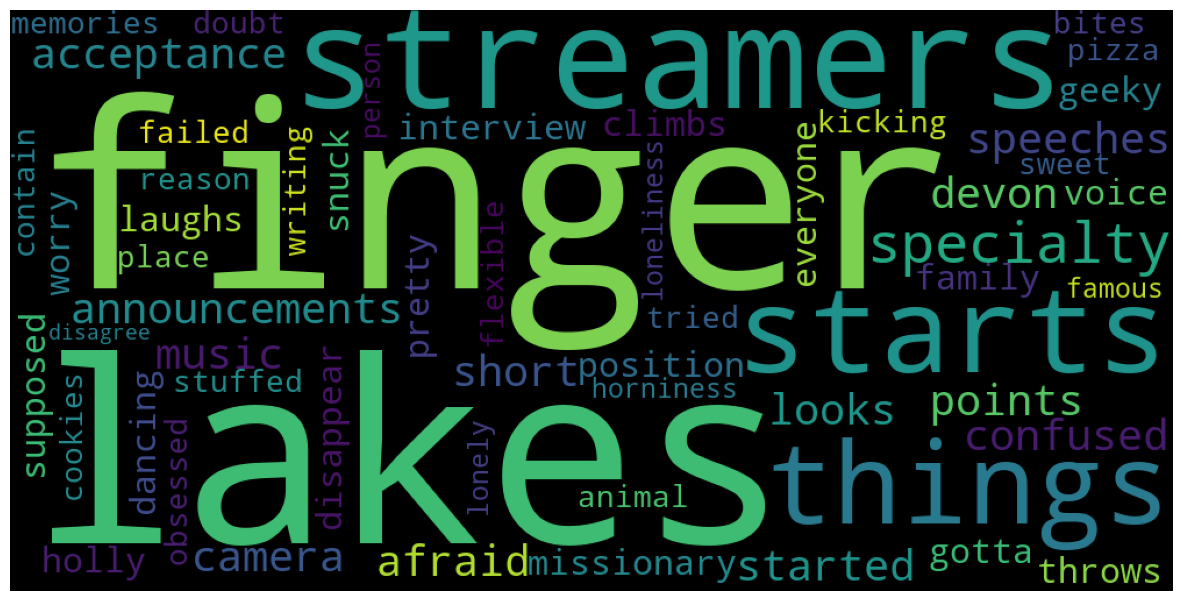

In [295]:
word_cloud_per_category("fun, party and food")

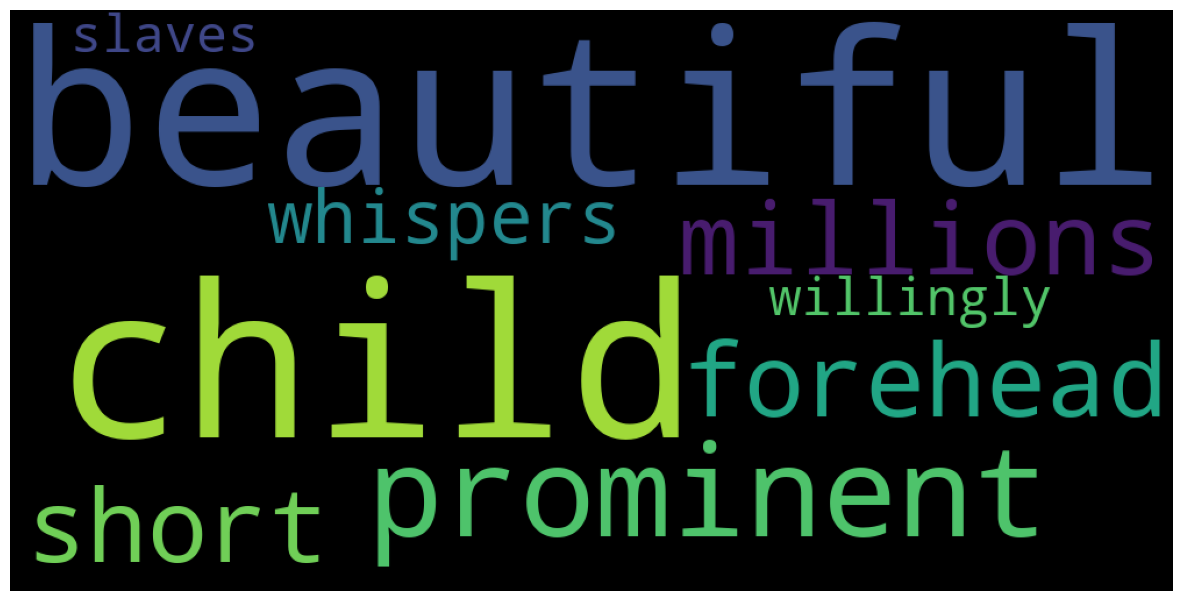

In [296]:
word_cloud_per_category("love")

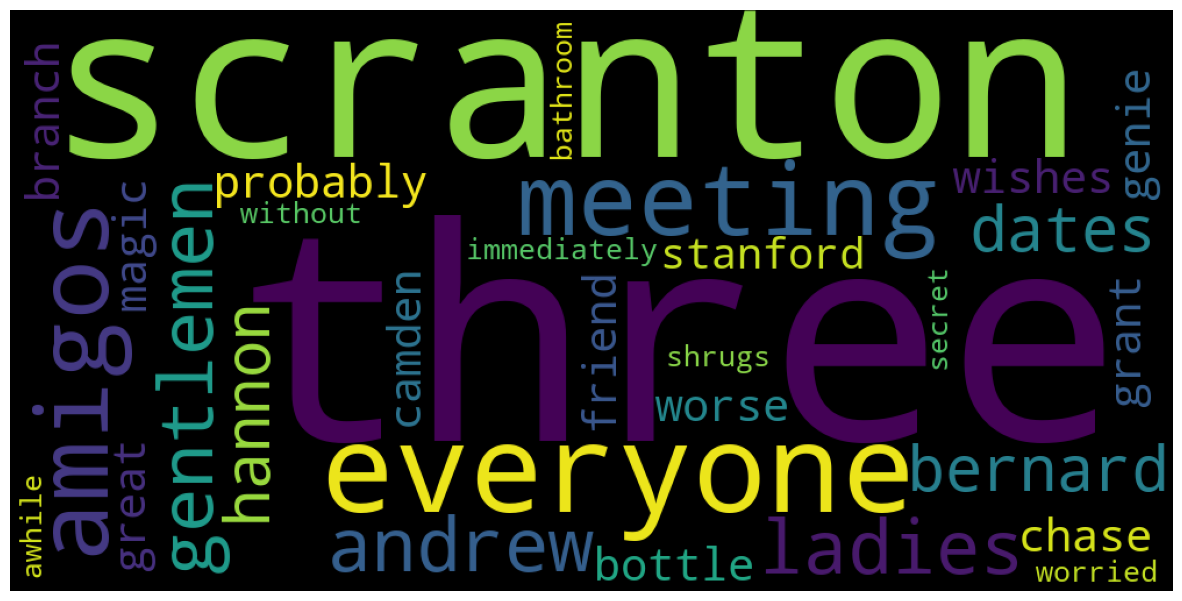

In [297]:
word_cloud_per_category("friendship")

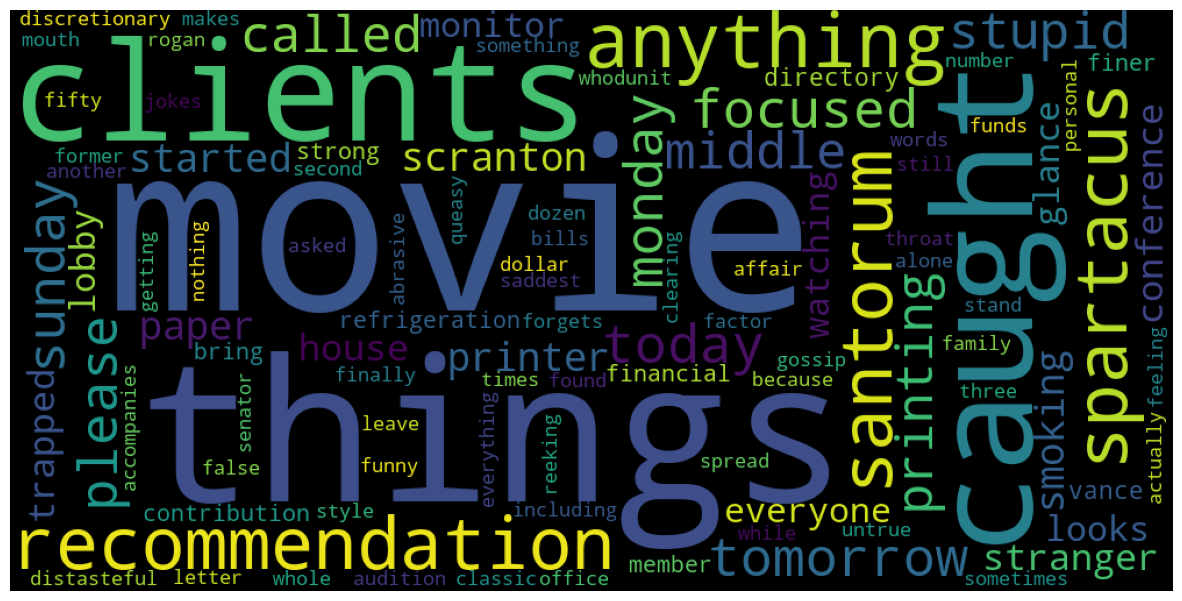

In [298]:
word_cloud_per_category("business and management")